In [2]:
cd drive/MyDrive/profile_labs/facial_recognition

/content/drive/MyDrive/profile_labs/facial_recognition


In [3]:
import os
import numpy as np
from imageio import imread
import matplotlib.pyplot as plt
import scipy
from scipy import linalg as lin
from scipy import sparse
from scipy.sparse import csc_matrix
from scipy.sparse.linalg import svds, eigs

In [11]:
def show(image, m=200, n=180):
    """Plot the flattened grayscale 'image' of width 'w' and height 'h'.
    
    Parameters:
        image ((mn,) ndarray): A flattened image.
        m (int): The original number of rows in the image.
        n (int): The original number of columns in the image.
    """
    reshapedFace = np.reshape(image, (m,n))
    plt.imshow(reshapedFace, cmap = "gray")

In [12]:
def show_multiple(image_list, title_list, suptitle="", m=200, n=180):
    """Displays multiple pictures in a single row. 
    
    Display more than 3 faces at your own peril."""
    
    # create subplots
    num_images = len(image_list)
    fig, axes = plt.subplots(1, num_images)
    
    fig.suptitle(suptitle)
    
    # plot each image
    for i, image in enumerate(image_list):
        # reshape images
        image = image.reshape(m, n)
        axes[i].imshow(image, cmap="gray")
        axes[i].set_title(title_list[i])
        axes[i].axis("off")

    # render images
    plt.show()

In [5]:
def get_faces(path="./faces94"):
    """Traverse the specified directory to obtain one image per subdirectory. 
    Flatten and convert each image to grayscale.
    
    Parameters:
        path (str): The directory containing the dataset of images.  
    
    Returns:
        ((mn,k) ndarray) An array containing one column vector per
            subdirectory. k is the number of people, and each original
            image is mxn.
    """
    # Traverse the directory and get one image per subdirectory.
    faces = []
    for (dirpath, dirnames, filenames) in os.walk(path):
        for fname in filenames:
            if fname[-3:]=="jpg":       # Only get jpg images.
                # Load the image, convert it to grayscale,
                # and flatten it into a vector.
                faces.append(np.ravel(imread(dirpath+"/"+fname, as_gray=True)))
                break
    # Put all the face vectors column-wise into a matrix.
    return np.transpose(faces)


def sample_faces(k, path="./faces94"):
    """Generate k sample images from the given path.

    Parameters:
        n (int): The number of sample images to obtain. 
        path(str): The directory containing the dataset of images.  
    
    Yields:
        ((mn,) ndarray): An flattend mn-array representing a single
        image. k images are yielded in total.
    """
    files = []
    for (dirpath, dirnames, filenames) in os.walk(path):
        for fname in filenames:
            if fname[-3:]=="jpg":       # Only get jpg images.
                files.append(dirpath+"/"+fname)

    # Get a subset of the image names and yield the images one at a time.
    test_files = np.random.choice(files, k, replace=False)
    for fname in test_files:
        yield np.ravel(imread(fname, as_gray=True))

In [6]:
class FacialRec(object):
    """Class for storing a database of face images, with methods for
    matching other faces to the database.
    
    Attributes:
        F ((mn,k) ndarray): The flatten images of the dataset, where
            k is the number of people, and each original image is mxn.
        mu ((mn,) ndarray): The mean of all flatten images.
        Fbar ((mn,k) ndarray): The images shifted by the mean.
        U ((mn,k) ndarray): The U in the compact SVD of Fbar;
            the columns are the eigenfaces.
    """
    def __init__(self, path='./faces94'):
        """Initialize the F, mu, Fbar, and U attributes.
        This is the main part of the computation.
        """
        self.path = path
        self.F = get_faces(path)
        self.mu = np.mean(self.F, axis=1)
        self.Fbar = self.F - np.vstack(self.mu)
        self.U,self.S,self.V = np.linalg.svd(self.Fbar, full_matrices=False)
            
    # Problem 3
    def project(self, A, s):
        """Project a face vector onto the subspace spanned by the first s
        eigenfaces, and represent that projection in terms of those eigenfaces.
        
        Parameters:
            A((mn,) or (mn,l) ndarray): The array to be projected. 
            s(int): the number of eigenfaces.
        Returns: 
            ((s,) ndarray): An array of the projected image of s eigenfaces.
        """
        return self.U[:,:s].T @ A
# show(facialRecognizer.V[100,:])
    # Problem 5
    def find_nearest(self, g, s=38):
        """Find the index j such that the jth column of F is the face that is
        closest to the face image 'g'.
        
        Parameters:
            g ((mn,) ndarray): A flattened face image.
            s (int): the number of eigenfaces to use in the projection.

        Returns:
            (int): the index of the column of F that is the best match to
                   the input face image 'g'.
        """
        # remove average face
        gShifted = g - self.mu
        # project as linear combination of 
        Fhat = self.project(self.Fbar, s)
        ghat = self.project(g-self.mu, s)
        return np.argmin(np.linalg.norm(Fhat - np.vstack(ghat), axis=0))


    # Problem 6
    def match(self, image, s=38, m=200, n=180):
        """Display an image along with its closest match from the dataset. 
        
        Parameters:
            image ((mn,) ndarray): A flattened face image.
            s (int): The number of eigenfaces to use in the projection.
            m (int): The original number of rows in the image.
            n (int): The original number of columns in the image.
        """
        j = self.find_nearest(image, s)
        match = self.F[:,j]

        plt.subplot(121)
        plt.title("Input Image")
        show(image, m, n)
        
        plt.subplot(122)
        plt.title("Closest Match")
        show(match, m, n)
        
        plt.show()



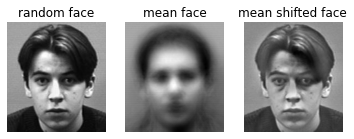

In [7]:
facialRecognizer = FacialRec('./faces94')

# face number index
j = 16

random_image = facialRecognizer.F[:,j]
average_face = (facialRecognizer.mu)
mean_shifted_face = (facialRecognizer.Fbar[:,j])
show_multiple([random_image, average_face, mean_shifted_face], ["random face", "mean face", "mean shifted face"])


3 eigenfaces: the lower the U_i the more of that eigenface is in every face


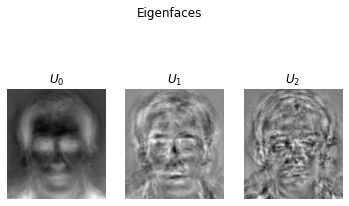

In [8]:
eigen_face1, eigen_face2, eigen_face3 = facialRecognizer.U[:,0], facialRecognizer.U[:,50], facialRecognizer.U[:,100]

print("3 eigenfaces: the lower the U_i the more of that eigenface is in every face")
show_multiple([eigen_face1, eigen_face2, eigen_face3], ["$U_0$", "$U_1$", "$U_2$"], "Eigenfaces")


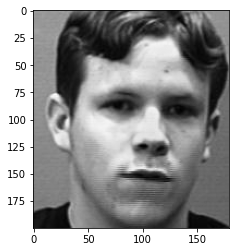

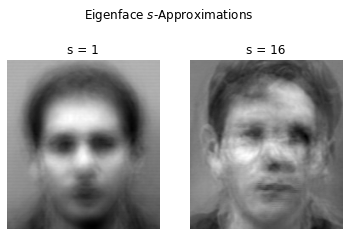

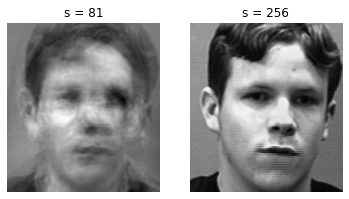

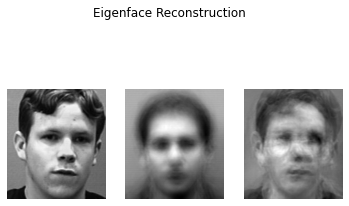

In [21]:

# get the j'th face
j = 20

rec = FacialRec()

# display j'th face
face = rec.Fbar[:, j]
show(face + rec.mu)

# print 4 reconstructions of varying accuracies
faces = []
names = []
for i in range(1, 5):
    names.append(f"s = {i**4}")

    if i == 3:
      i = 2

    # project face
    proj = rec.project(face, i**4)

    # reconstruct face
    recon = rec.U[:, :i**4] @ proj + rec.mu



    # show reconstruction
    faces.append(recon)

show_multiple(faces[:2], names[:2], r"Eigenface $s$-Approximations")
show_multiple(faces[2:], names[2:])

show_multiple([face + rec.mu, faces[0], faces[1]], ["", "",  ""], 
              "Eigenface Reconstruction")


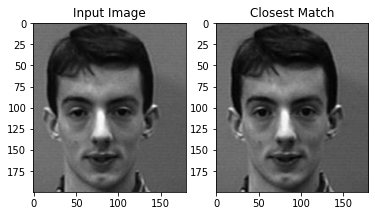

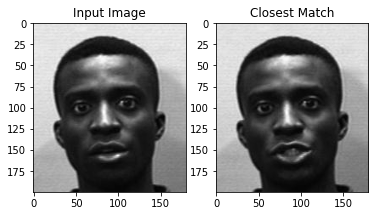

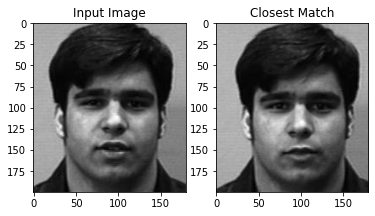

In [20]:
facialRecognizer = FacialRec()

for i, test_image in enumerate(sample_faces(3)):
    facialRecognizer.match(test_image)

plt.show()